<a href="https://colab.research.google.com/github/katyreena/MAI/blob/main/CUDA/Labs_2022/ParalellPrograming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MPI+pyTorch
###Этап А.  
* MasterNode рассылает ComputeNodes нейронки и части датасета для обучения  
* ComputeNodes обучают свои модели и информируют MasterNode об этом  

###Этап Б. Inference  
* К MasterNode передается объект данных для предсказаения.  
* MasterNode рассылает его всем ComputeNodes.  
* ComputeNodes делают предсказания и отправляют их MasterNode.  
* MasterNode на основе всех предсказаний делает голосование и выбирает предсказание.  

###Ансамбльный метод:  
* Усреднение (если задача регрессии)  
* Самый частовыбираемый класс (если задача классификации) или наиболее уверененный  

###Отчет: 
* Что такое MPI
* Что такое pyTorch
* В чем состоит задача
* Из чего состоит датасет
* Как выглядит форма голосования
* Выводы по сравненнию с использованием 1 процесса

In [ ]:
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

torch.manual_seed(17)

In [ ]:
train = pd.read_csv("/content/train.csv",dtype = np.float32)
test = pd.read_csv("/content/test.csv",dtype = np.float32)

train = train[0:100]
test = test[0:100]
submission = pd.read_csv("/content/sample_submission.csv")
submission = submission[0:100]

print("Train set shape:", train.shape)
print("Test set shape:", test.shape)

Train set shape: (100, 785)
Test set shape: (100, 784)


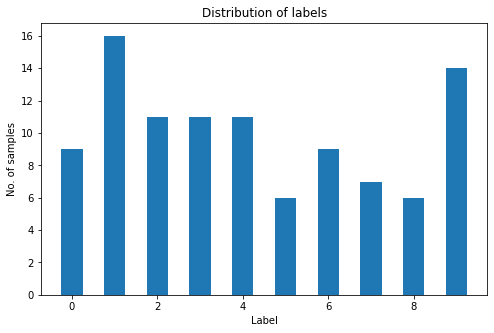

In [ ]:
label_dist = dict(train.label.value_counts())
number = label_dist.keys()
count = label_dist.values() 
   
fig = plt.figure(figsize = (8, 5)) 
   
plt.bar(number, count, width = 0.5) 
  
plt.xlabel("Label") 
plt.ylabel("No. of samples") 
plt.title("Distribution of labels") 
plt.show() 

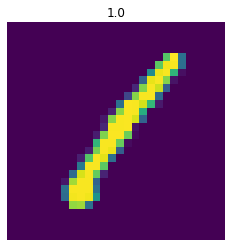

In [ ]:
plt.imshow(train.iloc[0, 1:].values.reshape(28,28))
plt.axis("off")
plt.title(str(train.iloc[0, 0]))
plt.show()

In [ ]:
#numpy.ndarray
labels = train.label.values
data = train.iloc[:, 1:].values / 255 # Normalization

In [ ]:
#torch.Tensor
labels = torch.from_numpy(labels).type(torch.LongTensor)
data = torch.from_numpy(data).view(data.shape[0], 1, 28, 28)

In [ ]:
#split the data
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size = 0.2, random_state = 42)

In [ ]:
class CustomTensorDataset(Dataset):

    def __init__(self, data, labels=None, transform=None):      
        self.data = data
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):       
        x = self.data[index]
        
        if self.transform is not None:
            x = self.transform(x)
        if self.labels is not None:
            y = self.labels[index]
            return x, y
        else:
            return x

    def __len__(self):    
        return self.data.size(0)

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=20, scale=(1.1, 1.1)),
    transforms.RandomCrop((28, 28), padding=2, pad_if_needed=True, fill=0, padding_mode='constant'),
    transforms.ToTensor()
])

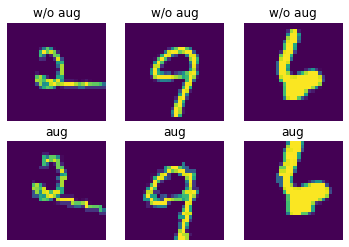

In [ ]:
sample = CustomTensorDataset(train_data[:3], train_labels[:3])
sample_aug = CustomTensorDataset(train_data[:3], train_labels[:3], transform=transform)

fig, axs = plt.subplots(2, 3)

for idx, item in enumerate(zip(sample, sample_aug)):
    
    im = item[0][0].squeeze().numpy()
    im_aug = item[1][0].squeeze().numpy()

    axs[0, idx].imshow(im)
    axs[0, idx].set_title("w/o aug")
    axs[0, idx].axis('off')
    
    axs[1, idx].imshow(im_aug)
    axs[1, idx].set_title("aug")
    axs[1, idx].axis('off')

In [ ]:
#create training and validation sets
trainset = ConcatDataset([
    CustomTensorDataset(train_data, train_labels),
    CustomTensorDataset(train_data, train_labels, transform=transform)
])
valset = CustomTensorDataset(val_data, val_labels)

In [ ]:
#create dataloaders to make use of batching and shuffling
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32, shuffle=False)

In [ ]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [ ]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [ ]:
model = ResNet_18(1, 10)

In [ ]:
#count trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

12556426

In [ ]:
#define everything we need for training
epochs = 1
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, is_inception=False):
    
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                inputs = transforms.functional.resize(inputs, (112, 112))



                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train': # Backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
model, _ = train_model(model, {"train": train_loader, "val": val_loader}, criterion, optimizer, epochs)

Epoch 0/0
----------
train Loss: 2.1164 Acc: 0.2562
val Loss: 2.2762 Acc: 0.1500

Training complete in 0m 13s
Best val Acc: 0.150000


In [ ]:
#prepare test set for the model
test = test.values / 255
test = torch.from_numpy(test).view(test.shape[0], 1, 28, 28)

In [ ]:
#prepare a dataloader with the test set
testset = CustomTensorDataset(test, None)
test_loader = DataLoader(testset, batch_size=1, shuffle=False)

In [ ]:
#turn on the evaluation mode and make predictions batch by batch (otherwise it lack gpu memory)
#to use predictions for the submission we first need to transfer to the cpu
model.eval()
labels = []
for inputs in test_loader:
    inputs = transforms.functional.resize(inputs, (112, 112))
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    predictions = predictions.to("cpu")
    labels.extend(predictions.numpy())
    break

In [ ]:
labels

[1]

mpi

In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 27.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438526 sha256=20c6627e5b71bd9f72eed8e7fff3dd9e2352506048b59ad879d127d6515e64a7
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


In [ ]:
from mpi4py import MPI
import time
import math
from scipy import random
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
data = None 

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=20, scale=(1.1, 1.1)),
    transforms.RandomCrop((28, 28), padding=2, pad_if_needed=True, fill=0, padding_mode='constant'),
    transforms.ToTensor()
])

if rank == 0:
  train = pd.read_csv("/content/train.csv",dtype = np.float32)
  data = [train[x*20: x*20 + 20] for x in range(size)]
  print("Рассылаем всем вычислительным узлам свою часть датасета")

interval = comm.scatter(data, root=0)

data = None
if rank != 0:
  train = interval
  labels = train.label.values
  data = train.iloc[:, 1:].values / 255 # Normalization
  labels = torch.from_numpy(labels).type(torch.LongTensor)
  data = torch.from_numpy(data).view(data.shape[0], 1, 28, 28)
  train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size = 0.2, random_state = 42)
  
  class CustomTensorDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):      
      self.data = data
      self.labels = labels
      self.transform = transform

    def __getitem__(self, index):       
      x = self.data[index]
       
      if self.transform is not None:
        x = self.transform(x)
      if self.labels is not None:
        y = self.labels[index]
        return x, y
      else:
        return x

    def __len__(self):    
      return self.data.size(0)
  trainset = ConcatDataset([
    CustomTensorDataset(train_data, train_labels),
    CustomTensorDataset(train_data, train_labels, transform=transform)
  ])
  valset = CustomTensorDataset(val_data, val_labels)
  train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
  val_loader = DataLoader(valset, batch_size=32, shuffle=False)
  
  class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x
  
  class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )
  model = ResNet_18(1, 10)
  epochs = 1
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
  lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
  
  def train_model(model, dataloaders, criterion, optimizer, num_epochs=50, is_inception=False):
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                inputs = transforms.functional.resize(inputs, (112, 112))



                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train': # Backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
  
  model, _ = train_model(model, {"train": train_loader, "val": val_loader}, criterion, optimizer, epochs)
  
  data = "Узел №" +str(rank) + " обучился"

data = comm.gather(data,root=0)

if rank == 0:
  print ("Этап 'А' выполнен! Узлы обучили модели:", data)
  print("Inference. Рассылаем ComputeNodes объект данных для предсказания")
  test = pd.read_csv("/content/test.csv",dtype = np.float32)
  data = test[0:100]

data = comm.bcast(data)

if rank != 0:
  test = data
  test = test.values / 255
  test = torch.from_numpy(test).view(test.shape[0], 1, 28, 28)
  testset = CustomTensorDataset(test, None)
  test_loader = DataLoader(testset, batch_size=1, shuffle=False)
  model.eval()
  labels = []
  for inputs in test_loader:
    inputs = transforms.functional.resize(inputs, (112, 112))
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    predictions = predictions.to("cpu")
    labels.extend(predictions.numpy())
    break
  data = labels[0]


data = comm.gather(data,root=0)

if rank == 0:
  print ("Этап 'Б' выполнен! Предсказания получены")
  tmp = dict()
  for i in data[1:]:
    if i in tmp:
      tmp[i] += 1
    else:
      tmp[i] = 1
  max_val = max(tmp.values())
  final_dict = {k:v for k, v in tmp.items() if v == max_val}
  final = list(final_dict.keys())

  r = np.random.randint(0, len(final))

  print("Результат голосования: ", final[r])


In [ ]:
!mpirun -np 4 --allow-run-as-root python main.py

Рассылаем всем вычислительным узлам свою часть датасета



Этап 'А' выполнен! Узлы обучили модели: [None, 'Узел №1 обучился', 'Узел №2 обучился', 'Узел №3 обучился']
Inference. Рассылаем ComputeNodes объект данных для предсказания
Этап 'Б' выполнен! Предсказания получены
Результат голосования:  9
